<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

## *Data Science Unit 4 Sprint 2 Assignment 2*

# Document Representations: Bag-Of-Words

In [4]:
import re
import string

!pip install -U nltk

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize # Sentence Tokenizer
from nltk.tokenize import word_tokenize # Word Tokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

     |████████████████████████████████| 1.5MB 2.8MB/s 
  Stored in directory: /root/.cache/pip/wheels/41/c8/31/48ace4468e236e0e8435f30d33e43df48594e4d53e367cf061
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 1) (optional) Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [13]:
from google.colab import files
files.upload()

Saving Data Scientist Jobs, Employment   Indeed.com.html to Data Scientist Jobs, Employment   Indeed.com.html


{'Data Scientist Jobs, Employment   Indeed.com.html': b'<!DOCTYPE html>\n<html lang="en" dir="ltr">\n<head>\n<meta http-equiv="content-type" content="text/html;charset=UTF-8">\n<script type="text/javascript" src="/s/e7e2a1c/en_US.js"></script>\n<script>window.indeed=window.indeed||{};indeed.crashtext=indeed.crashtext||{};indeed.crashtext.populate=indeed.crashtext.populate||function(c,g){var d=window[g];if(d){var e=d[""]||{},h=e.salt;if(e.hasOwnProperty("salt"))for(var b in c){for(var a=void 0,a=h,f=b.length;f;)a=33*a^b.charCodeAt(--f);a>>>=0;e.hasOwnProperty("id_length")&&(a=String(a).substring(0,e.id_length));d[a]=c[b]}else for(b in c)d[b]=[null].concat(c[b])}};indeed.crashtext.populate({"Get Job Alerts for this search":["See new jobs for this search"],"Create job alert":["Turn on"]}, \'indeed.i18n.localeData\')</script>\n<link href="/s/684a333/jobsearch_all.css" rel="stylesheet" type="text/css">\n<link rel="alternate" type="application/rss+xml" title="Data Scientist Jobs, Employment"

In [0]:
from bs4 import BeautifulSoup
import requests


soup=BeautifulSoup()

page_link='https://www.indeed.com/jobs?q=data+scientist&l='

page_response = requests.get(page_link, timeout=5)

page_content = BeautifulSoup(page_response.content, 'html.parser')

text_content=[]


In [20]:
url= 'https://raw.githubusercontent.com/Jeffrowetull/DS-Unit-4-Sprint-1-NLP/master/module2-vector-representations/job_listings.csv'
df=pd.read_csv(url).drop(columns=['Unnamed: 0'])
df.head()

,description,title
0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


## 2) Use Spacy to tokenize / clean the listings 

In [21]:
import spacy
from spacy.tokenizer import Tokenizer
!pip install en_core_web_sm

In [0]:
nlp = spacy.load('en_core_web_sm')
tokenizer = Tokenizer(nlp.vocab)
ignore = ['<','>','=','\\','|','||','/']
tokens = []

for doc in tokenizer.pipe(df['description'],batch_size=500):
  doc_tokens = []
  for token in doc:
    if (token.is_stop == False) and (token.is_punct == False):
      word = True
      for char in ignore:
        if char in token.text:
          word = False
          break
      if word:
        doc_tokens.append(token.text.lower())
  tokens.append(doc_tokens)
  
df['tokens'] = tokens

# 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer as cv

vect = cv(stop_words='english',lowercase=False,tokenizer=lambda x:x)
doc = df.tokens
dtm = vect.fit_transform(doc)
dtm_df=pd.DataFrame(dtm.todense(),columns=vect.get_feature_names())
dtm_df.head()

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,"""ability","""apply""","""best","""big","""can","""can-do""","""completeness","""customer","""engineering","""fintech""","""full-stack","""get","""hands-on""","""helio""","""my","""no","""numbers-based""","""open-sourcing""","""pillar","""saas""","""storytelling""","""success""","""tmus"")","""transforming","""view",#1,"#8954,",#autodeskinterns,"#hcdagile,","$1,000",$1.66,$10,"$100,000","$100,908",$10b,$110k,"$125,000","$126,062",$14.4,$15,...,years),"years,",yes,"yes,","yet,",yeti,"yeti,",yield,york,"york,",york.,you!,"you!""",you'd,you'll,you're,you've,"you,",you.,you:,you?,young,"young,","yourself),",yourself.,"youtube,",yrs,"yrs,",yrs.,zenreach,zero.,zeus,zf,"zheng,",zillow,zoom,zuckerberg,zurich,~$70,~4
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 4) Visualize the most common word counts

<BarContainer object of 10 artists>

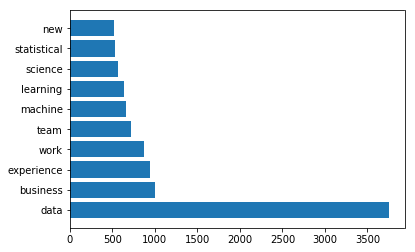

In [29]:
top_ten = dtm_df.sum().sort_values(ascending=False)[:10]
plt.barh(top_ten.index,top_ten.values)

 # 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer as tv


data=[]
for _ in list(df.tokens):
  data.append(' '.join(_))

tf = tv(max_features=5000,stop_words='english',min_df=5)

dtm=tf.fit_transform(data)
df_tf=pd.DataFrame(dtm.todense(),columns=tf.get_feature_names())
df_tf.head()

,000,10,100,11,12,15,17,20,200,2013,2015,2018,2019,25,30,3rd,40,401,401k,50,500,60,600,70,800,90,ab,abilities,ability,able,academic,academics,accelerate,accelerating,accept,access,accessible,accommodation,accommodations,accomplish,...,web,website,week,weekly,weeks,weka,welcome,wellness,white,wide,wider,willing,willingness,win,windows,winning,women,word,work,worked,workers,workflow,workflows,workforce,working,workload,workplace,works,world,worldwide,worth,wrangling,write,writing,written,www,year,years,yes,york
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.082458,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.055241,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.16478,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.080326,0.0,0.0,0.0,0.0,0.0,0.045407,0.0,0.0,0.0,0.0,0.0,0.058865,0.0,0.0,0.0,0.067982,0.0,0.0,0.0,0.00000,0.117393,0.040813,0.0,0.058696,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.059627,0.0,0.0,0.0,0.0,0.0,0.077299,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.059718,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.077195,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.164677,0.0,0.0


 # 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [34]:
from sklearn.neighbors import NearestNeighbors as nn


nn = nn(n_neighbors=5,algorithm='ball_tree')
nn.fit(dtm.todense())

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [46]:
ideal = ['blockchain junior remote']
ideal_job = tf.transform(ideal).todense()

nn.kneighbors(ideal_job)

(array([[1.26242909, 1.26242909, 1.27883256, 1.32360897, 1.3256187 ]]),
 array([[123,  23, 256, 203, 173]]))

In [0]:
def insert_newlines(string, every=64):
    return '\n'.join(string[i:i+every] for i in range(0, len(string), every))

In [60]:
print(insert_newlines(data[123],every=150))

technology data company food industry. believe transparency, diversity, merit fostering culture accountability, personal impact career member product 
engineering team motiion unique opportunity turning previously scattered inconsistently structured data directly actionable food industry insights red
uce waste, increase freshness proven track record reading data making solid conclusions. know art science analytics know find answers data, know quest
ions asked place data help bolster conclusions. love engaging customers, learn challenges dive data solve building product engineering team breadth co
mbined experiences collaboratively build great products. hard requirements specific educational background, technology, experience geographical locati
on. looking specific traits people work with. able check boxes, aspire signs great oriented. background mathematics, statistics, machine learning, art
ificial intelligence, else, experience intuitively shortlist tools approaches business custome

In [62]:
print(insert_newlines(data[256],every=150))

ccs data scientist responsible supporting ccs digital service operations teams data analytics drive improved remote service efficiency improved custom
er opportunities rules drive service efficiencies performing retrospective analysis historical machine log data vs service dispatches, apply machine l
earning techniques learn know use funnel improvements rules remote look remote service efficiency opportunities variable cost productivity service dis
patch data, necessary lead regional teams support drive process improvements implement changes reduce cost improve customer data visualizations demons
trate learnings opportunities support wide range pareto pain analysis efforts add automatic root cause analysis service dispatch data subsequently imp
rove remote triage enable right deployment smart triage ccs expertise learning dispatch &amp; machine network subject matter experts regions engineeri
ng teams support sanity check assumptions understanding context service dispatch product quali

In [63]:
print(insert_newlines(data[203],every=150))

synthesizing interpreting proposal development, special develop reports analyze data measure outcomes analyze data sources recommend best data reporti
ng development trend junior members regular industry strategic data based recommendations highlight data problem solving relation eq health curiosity 
good industry


## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.